In [10]:
import numpy as np
import serial
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

tf.__version__

'2.10.0'

In [11]:
# load extracted dataset from MIT-BIH dataset Arrhythmia database (only N, A, V, R, L)
#data = tf.keras.datasets.fashion_mnist

X_train_full = np.load('Data/X.npy')
y_train_full = np.load('Data/y.npy')
X_test = np.load('Data/X_val.npy')
y_test = np.load('Data/y_val.npy')

# remove distance between two consecutive peaks
X_train_full = np.array(X_train_full[:,:-2])
X_test = np.array(X_test[:,:-2])

print("X_train_full shape from MIT-BIH:",X_train_full.shape)
print("X_text shape from MIT-BIH:",X_test.shape)

# save data for reuse...
np.save('X_train_full.npy', X_train_full)
np.save('X_test.npy', X_test)
np.save('y_train_full.npy', y_train_full)
np.save('y_test_arrythmia_classes.npy', y_test)



X_train_full shape from MIT-BIH: (5000, 181)
X_text shape from MIT-BIH: (5000, 181)


In [12]:
# transform y_train class characters in number !
class_names = {'A':'Atrial premature contraction (A)','V':'Premature venticular contraction (V)','N':'Normal beat (N)','L':'Left bundle branch block (L)','R':'Right bundle branch block beat (R)'}
mapping_to_numbers = {}
y_train_full_number = np.zeros((len(y_train_full)))
for i, raw_label in enumerate(y_train_full):
    if raw_label not in mapping_to_numbers:
        mapping_to_numbers[raw_label] = len(mapping_to_numbers)
    y_train_full_number[i] = mapping_to_numbers[raw_label]
# [0. 1. 2. 3. 1. 2.]
print("Class names for numbers:", mapping_to_numbers)
# could be {'A': 0, 'V': 1, 'N': 2, 'L': 3, 'R': 4}
y_test_number = np.zeros((len(y_test)))
for i in range(len(y_test)):
    y_test_number[i] = mapping_to_numbers[y_test[i]]

print("y_train shape:", y_train_full.shape)
print("y_train shape with number:", y_train_full_number.shape)

np.save('y_test.npy', y_test_number)

Class names for numbers: {'A': 0, 'V': 1, 'N': 2, 'L': 3, 'R': 4}
y_train shape: (5000,)
y_train shape with number: (5000,)


In [13]:
# TBD: Normalize data ???
# X_train_full = X_train_full / 255.0
# X_test  = X_test / 255.0
# Faire la moyenne du Dataset
        
# Split training dataset in two dataset: the validation and training sets
X_valid, X_train = X_train_full[:2500], X_train_full[2500:]
y_valid, y_train = y_train_full_number[:2500], y_train_full_number[2500:]

print(f'Taille de X_train: {X_train.shape}')
print(f'Taille de X_valid: {X_valid.shape}')

# Specify the model's architecture

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = [len(X_train[0]),1]),
     
    tf.keras.layers.Dense(90, activation='relu'), # tanh activation function which is the same of the publication
    tf.keras.layers.Dense(30, activation='tanh'), # tanh activation function which is the same of the publication
    tf.keras.layers.Dense(5, activation='softmax'), #sigmoid
])


# Specify the loss function, optimizer, metrics
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.011),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train the model
history = model.fit(
    X_train, y_train, epochs=15,
    validation_data = (X_valid, y_valid),
    verbose=0
)

model.summary()

Taille de X_train: (2500, 181)
Taille de X_valid: (2500, 181)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 181)               0         
                                                                 
 dense_5 (Dense)             (None, 90)                16380     
                                                                 
 dense_6 (Dense)             (None, 30)                2730      
                                                                 
 dense_7 (Dense)             (None, 5)                 155       
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________


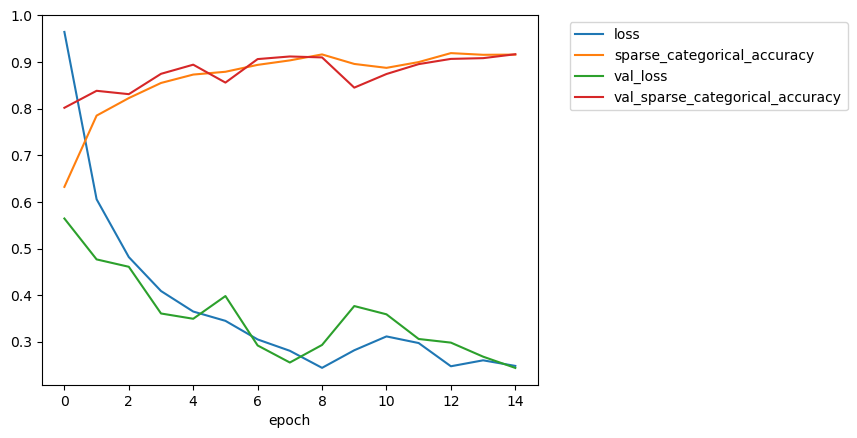

In [14]:
# display results
pd.DataFrame(history.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [15]:
# Precision du modèle
loss, acc = model.evaluate(X_test, y_test_number)

157/157 [==============================] - 0s 2ms/step - loss: 0.2852 - sparse_categorical_accuracy: 0.9032


In [16]:
# save model 
model.save("mlp.keras")
keras_model = tf.keras.models.load_model('mlp.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()
with open('converted_model.tflite', 'wb') as f:     
  f.write(tflite_model)
    

INFO:tensorflow:Assets written to: C:\Users\grego\AppData\Local\Temp\tmpdz417n3e\assets


INFO:tensorflow:Assets written to: C:\Users\grego\AppData\Local\Temp\tmpdz417n3e\assets


In [17]:
import serial
import numpy as np

PORT = "COM5"


def synchronise_UART(serial_port):
    """
    Synchronizes the UART communication by sending a byte and waiting for a response.

    Args:
        serial_port (serial.Serial): The serial port object to use for communication.

    Returns:
        None
    """
    while (1):
        serial_port.write(b"\xAB")
        ret = serial_port.read(1)
        #print(f"Received {ret}")  # Ajout du print
        if (ret == b"\xCD"):
            serial_port.read(1)
            break


def send_inputs_to_STM32(inputs, serial_port):
    """
    Sends a numpy array of inputs to the STM32 microcontroller via a serial port.

    Args:
        inputs (numpy.ndarray): The inputs to send to the STM32.
        serial_port (serial.Serial): The serial port to use for communication.

    Returns:
        None
    """
    inputs = inputs.astype(np.float32)
    buffer = b""
    for x in inputs:
        buffer += x.tobytes()
    serial_port.write(buffer)


def read_output_from_STM32(serial_port):
    """
    Reads 10 bytes from the given serial port and returns a list of float values obtained by dividing each byte by 255.

    Args:
    serial_port: A serial port object.

    Returns:
    A list of float values obtained by dividing each byte by 255.
    """
    output = serial_port.read(5)

    float_values = [int(out)/255 for out in output]
    return float_values


def evaluate_model_on_STM32(iterations, serial_port):
    """
    Evaluates the accuracy of a machine learning model on an STM32 device.

    Args:
        iterations (int): The number of iterations to run the evaluation for.
        serial_port (Serial): The serial port object used to communicate with the STM32 device.

    Returns:
        float: The accuracy of the model, as a percentage.
    """
    accuracy = 0
    for i in range(iterations):
        print(f"----- Iteration {i+1} -----")
        send_inputs_to_STM32(X_test[i], serial_port)
        output = read_output_from_STM32(serial_port)
        if (np.argmax(output) == np.argmax(Y_test[i])):
          accuracy += 1 / iterations
        print(f"   Expected output: {Y_test[i]}")
        print(f"   Received output: {output}")
        print(f"----------------------- Accuracy: {accuracy:.2f}\n")
    return accuracy


if __name__ == '__main__':
    X_test = np.load("./Data/X_test.npy")
    Y_test = np.load("./Data/y_test_STM.npy")

    with serial.Serial(PORT, 115200, timeout=1) as ser:
        print("Synchronising...")
        synchronise_UART(ser)
        print("Synchronised")

        print("Evaluating model on STM32...")
        error = evaluate_model_on_STM32(100, ser)

SerialException: could not open port 'COM5': FileNotFoundError(2, 'Le fichier spécifié est introuvable.', None, 2)

In [ ]:
with serial.Serial(PORT, 115200, timeout=5) as ser:
    ser.write(b"\xAB")
    response = ser.read(2)  # Lire 2 octets pour tester
    print(f"Received from STM32: {response}")
